### Multi-PDF Chat Agent with RAG (LangGraph + Google Gemini + Streamlit)

#### Overview

Build a Retrieval-Augmented Generation (RAG) chat agent using LangGraph:

1. Accepts multiple PDFs

2. Extracts and preprocesses text

3. Embeds using Google Gemini embeddings

4. Stores vectors in Chroma (local) or Qdrant (production)

5. Uses LangGraph's graph-based agent orchestration to manage ingestion, retrieval, generation, and verification as separate nodes

6. Streamlit interface for chat & inspection

#### Why LangGraph here?

1. Modularity: Each step (ingestion, embedding, retrieval, LLM call, verification) is a node in the graph.

2. Control Flow: Can define conditional edges (e.g., if verification fails, re-retrieve with higher k).

3. Parallelism: Embedding multiple chunks in parallel.

4. Resumability: Graph states can be serialized and resumed — useful in long ingestion pipelines.

#### Graph Structure

Nodes:

1. IngestPDFs → loads & cleans documents

2. ChunkDocs → splits into overlapping chunks

3. EmbedDocs → generates embeddings, stores in vectorstore

4. RetrieveDocs → retrieves relevant chunks for a query

5. GenerateAnswer → LLM call with retrieved context

6. VerifyAnswer → validates citations; may loop back to retrieval if invalid

#### Define the state

In [18]:
# state.py
from typing import TypedDict, List
from langchain.docstore.document import Document
from langchain.vectorstores import Chroma

class PDF_CHAT_STATE(TypedDict):
    question: str # The question to be answered
    pdf_paths: List[str]  # List of paths to the PDF files
    chunks: List[Document] # List of document chunks created from the PDFs
    vectordb: Chroma # Vector store for the PDF chunks
    retrieved_docs: List[Document] 


Stores everything the LangGraph agents need: uploaded PDFs, chunks, vector DB, retrieved docs, user query, and LLM response.

#### Node: PDF ingestion + chunking

In [14]:
# nodes.py
import tempfile
from rag_pipeline_langchain.ingest import load_multiple_pdfs
from rag_pipeline_langchain.utils import make_text_chunks
from rag_pipeline_langchain.embeddings_store import create_or_load_vectorstore, make_embedder
from rag_pipeline_langchain.qa_agent import make_qa_chain, run_qa
#from state import PDFChatState


# Node: PDF ingestion + chunking
def ingest_pdfs_node(pdf_files, state: PDF_CHAT_STATE) -> PDF_CHAT_STATE:
    paths = []
    for f in pdf_files:
        tf = tempfile.NamedTemporaryFile(delete=False, suffix=".pdf")
        tf.write(f.read())
        tf.flush()
        paths.append(tf.name)
    state['pdf_paths'] = paths

    docs = load_multiple_pdfs(paths)
    chunks = make_text_chunks(docs)
    state['chunks'] = chunks
    return state

QA agent is ready to use.


#### Node: Vector DB creation / load

In [16]:
# Node: Vector DB creation / load
def init_vectordb_node(state: PDF_CHAT_STATE, persist_directory="./chroma_2_db") -> PDF_CHAT_STATE:
    if 'vectordb' not in state or state['vectordb'] is None:
        embeddor = make_embedder()
        vectordb = create_or_load_vectorstore(
            docs=state['chunks'],
            persist_directory=persist_directory,
            embedding_model=embeddor
        )
        state['vectordb'] = vectordb
    return state


#### Node: QA with verification

In [17]:
# Node: QA with verification
def qa_node(question, state: PDF_CHAT_STATE, top_k=5) -> PDF_CHAT_STATE:
    state['question'] = question
    qa_chain = make_qa_chain(state['vectordb'], top_k=top_k)
    resp = run_qa(qa_chain, question)
    state['llm_response'] = resp['result']
    state['retrieved_docs'] = resp.get('source_documents', [])
    return state

#### Build LangGraph graph
We create a StateGraph and connect edges between nodes.

In [20]:
# graph_runner.py
from langgraph.graph import StateGraph,START,END
#from state import PDFChatState
#from nodes import ingest_pdfs_node, init_vectordb_node, qa_node

# Initialize empty graph
graph = StateGraph(PDF_CHAT_STATE)

# Register nodes
graph.add_node("ingest", ingest_pdfs_node)
graph.add_node("vector_db", init_vectordb_node)
graph.add_node("qa", qa_node)

# Connect edges (linear flow)
graph.add_edge(START, "ingest")
graph.add_edge("ingest", "vector_db")
graph.add_edge("vector_db", "qa")
graph.add_edge('qa', END)


In [21]:
workflow = graph.compile()

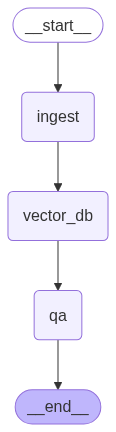

In [22]:
workflow

In [24]:
intial_state = {
    "question":"give me a summary of the PDF"
}

In [25]:
workflow.invoke(intial_state)

TypeError: ingest_pdfs_node() missing 1 required positional argument: 'state'